In [3]:
!pip install sentence-transformers -Uq


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [1]:
!pip install datasets
!pip install  accelerate -U 

  Using cached datasets-2.14.5-py3-none-any.whl (519 kB)
  Using cached xxhash-3.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached aiohttp-3.8.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Using cached multidict-6.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (114 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
  Using cached yarl-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (268 kB)
  Using cached frozenlist-1.4.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (225 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Using cached accelerate-0.22.0-py3-none-any.whl (251 kB)
  Attempting uninstall: accelerate
   

# finetune 模型

In [4]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from datasets import load_dataset
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
import torch
import logging

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt = '%Y-%m-%d %H:%M:S', level=logging.INFO, handlers =[LoggingHandler()] )

## 从hf加载模型

In [6]:
modelB = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
# modelB=SentenceTransformer('intfloat/multilingual-e5-large')

2023-09-12 02:16:S - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
2023-09-12 02:16:S - Use pytorch device: cuda


In [8]:
# dataset_id = "embedding-data/sentence-compression"
# dataset = load_dataset(dataset_id)

### 加载TopWar原始语料

In [13]:
import os,datasets
# filenames = os.listdir('topwar_faq')
filenames = ['cleaned_topwar_enrich_faq_0911.faq','topwarfaq230908.faq']

In [14]:
def parse_faq(file_content,QA_SEP='====='):
    arr = file_content.split(QA_SEP)
    list_arr = []
    for item in arr:
        question, answer = item.strip().split("\n", 1)
        question = question.replace("Question: ", "")
        answer = answer.replace("Answer: ", "")
        list_arr.append((answer,question))
    return list_arr

all_datas = []
for fn in filenames:
    if fn == '.ipynb_checkpoints':
        continue
    with open(f"docs/{fn}") as f:
        data = f.read()
        all_datas += parse_faq(data)
print(f"data size:{len(all_datas)}")

data size:5235


### 加载enrich之后的语料

In [9]:
import pickle
pklfn = 'docs/topwarfaq0817.pkl'
all_datas = []
with open(pklfn, 'rb') as f:
    all_datas = pickle.load(f)

In [10]:
print(f"data size:{len(all_datas)}")

data size:4704


## 加载csv预料

In [11]:
import pandas as pd
import re

In [12]:
df = pd.read_csv('docs/topwar_faq_new.csv')
df=df[['answer','question']].dropna()

In [13]:
df['question'] = df['question'].map(lambda x: re.sub(r'^(\d+.\s?)','',x.strip()))

In [14]:
df.sample(10)

,answer,question
4391,超级矿工是一个城市外观\n超级矿工的效果是：\n使用属性\n采集速度提升+50%\n采集负重...,超级矿工
717,巨人杀手是一个装饰物\n巨人杀手的说明:比较常见的装饰物\n巨人杀手的效果:对战争之源攻击增...,巨人杀手有什么效果？
1269,工业时代-浮台吊车是一个装饰物\n工业时代-浮台吊车的说明:给我一个动滑轮就能吊起整个口袋奇...,工业时代-浮台吊车
805,能获取到您需要的物品，帮助盟友不会消耗自身物品,联盟帮助有什么用?我帮助盟友会消耗我自己的物品吗？
2715,欢乐大脚是一个队列外观\n欢乐大脚的拥有属性：野外行军速度提高+10%,队列外观-欢乐大脚
3615,等级到达14级可以建造战区纪念碑。,建筑物战区纪念碑多少级后开启？
568,雪驰冰车是一个队列外观\n雪驰冰车的拥有属性：野外行军速度提高+10%,雪驰冰车的野外行军速度提高百分之几？
2848,"1.使用【军阵:毒蝎】时,所属阵位士兵受到伤害时,有概率触发反击，2.反击无法触发英雄技能，...",阵型指挥所反击号角如何触发反击？
2122,祥龙城堡是一个城市外观\n祥龙城堡的效果是：\n使用属性\n全部单位攻击加成\n全部单位生命...,祥龙城堡有什么效果？
183,云隐灵山是一个城市外观\n云隐灵山的效果是：\n使用属性\n全部单位生命加成+10%\n全体...,云隐灵山有什么属性？


In [15]:
#增加问题对标志

def convert_vocab_to_token_id(vocab, word):
    vocab_dict = {word: idx for idx, word in enumerate(vocab)}
    # token_ids = [vocab_dict.get(word, -1) for word in words]
    token_id = vocab_dict.get(word, -1)
    return token_id


vocab = list(set(df['answer']))

In [16]:
df['idx'] = df['answer'].map(lambda x:convert_vocab_to_token_id(vocab,x)) 

In [17]:
all_datas=df[['answer','question']].values.tolist()

## 准备dataset

In [15]:
train_examples = []

for i in range(len(all_datas)):
    example = all_datas[i]
    train_examples.append(InputExample(texts=[example[0], example[1]]))

In [17]:
train_examples[4000].texts

['铁壁是一种英雄技能。效果：直接伤害减免，开场立即释放（释放顺序仅次于[洛克菲尔德]技能），效果最大生效值为70%，不同英雄的[铁壁]效果同时存在时，加成效果最大的生效。',
 '铁壁']

In [18]:

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)
train_loss = losses.MultipleNegativesRankingLoss(model=modelB)
num_epochs = 2
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [ ]:
torch.cuda.empty_cache()
modelB.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
           # evaluator=evaluator,
            # evaluation_steps=5,
           output_path='./finetuned-sentence-embedding',
          warmup_steps=warmup_steps)

## 从本地加载finetuned的模型

In [ ]:
# modelB = SentenceTransformer('./finetuned-sentence-embedding')

## 抽样

In [39]:
from sentence_transformers import evaluation,util
import pandas as pd

In [41]:
df = pd.DataFrame(all_datas,columns=['answer','question'])
df

,answer,question
0,装饰物可以通过摆放在基地，每周会根据活跃度获得一个免费的永久装饰物，也可以通过购买或者参与活...,我如何获得装饰物？
1,你最多可以放置20个装饰物，但是每个装饰物的属性都是有限的，并且只有一个建筑能够放置装饰物，...,我最多能放置多少个装饰物？
2,"在主城市中，你可以找到""建筑-神奇宝箱""的按钮，点击后会显示你所有已放置的装饰物的属性，还可...",我如何查看我的装饰物的属性？
3,在合成高等级装饰物时，需要将三个同等级的装饰物进行合成，合成后会得到一个更高一级的装饰物，但...,我如何合成更高等级的装饰物？
4,由于游戏内显示的最多有一位小数，所以当你从0.2提升到0.24时，游戏内会显示0.2，但是实...,我的游戏等级显示为什么只有0.2而没有显示0.24？
...,...,...
5230,专属技能万能碎片是一个道具，可用于在专属技能商店兑换心仪的专属技能,专属技能万能碎片
5231,专属技能万能碎片不会过期，可长期使用,专属技能万能碎片会过期吗
5232,职业天赋重置券是一个道具，在道具商店售价是5000钻石，\n能将以前已研究完成的职业天赋进度...,职业天赋重置券有什么用
5233,职业转换券是一个道具，在道具商店售价是10000钻石，\n使用后可以获得重新选择职业的机会,职业转换券有什么用


## 抽样20%数据拿出来算距离

In [159]:
### 抽取一部分，做交叉负样本
# sample_size = int(len(all_datas)*0.2)
# df_sample_1 = df.sample(sample_size)
# df_sample_2 = df.sample(sample_size)

# ##去除sample1 和 sample 2中的重复部分
# df_dup_sample = df_sample_1.join(df_sample_2,rsuffix='_r')
# df_dup_sample = df_dup_sample[~df_dup_sample.question_r.isna()][['question','answer']]

# df_sample_1_dedup = df_sample_1.join(df_dup_sample,how='left',rsuffix ='_r')
# df_sample_1_dedup = df_sample_1_dedup[df_sample_1_dedup.question_r.isna()]

# df_sample_2_dedup = df_sample_2.join(df_dup_sample,how='left',rsuffix='_r')
# df_sample_2_dedup = df_sample_2_dedup[df_sample_2_dedup.question_r.isna()]


# #将sample 1 的答案和sample 2 的问题组成负样本
# input_answer  = []
# input_question  = []
# for a,b in zip(df_sample_1_dedup.answer,df_sample_2_dedup.question):
#     input_answer.append(a)
#     input_question.append(b)
# print(f'negative sample size:{df_sample_2_dedup.shape[0]}')

In [160]:
# emb_answer = modelB.encode(input_answer)
# emb_question = modelB.encode(input_question)

In [162]:
input_answer  = []
input_question  = []
sample_size = int(len(all_datas)*0.2)
df_sample = df.sample(sample_size)
for a,b in zip(df_sample.answer,df_sample.question):
    input_answer.append(a)
    input_question.append(b)
print(f'sample size:{df_sample.shape[0]}')

sample size:1047


In [163]:
emb_answer = modelB.encode(input_answer)
emb_question = modelB.encode(input_question)

Batches: 100%|██████████| 33/33 [00:00<00:00, 36.52it/s]


## 将question和answer进行cross 对比，查看这个分布。
### 输出矩阵的对角线的结果代表的是正样本，其他非对角线的则是交叉样本（负样本）

In [165]:
# 计算所有q和a之间的相似度
cross_simsvalues = util.cos_sim(emb_answer,emb_question).flatten()

In [166]:
cross_sims_s = pd.Series(cross_simsvalues)

In [167]:
N = len(input_question)
pos_indices = [ i*N+i for i in range(N)] ##只取出正例的index

In [168]:
# 正样本的得分
pos_cross_sims_s = cross_sims_s[pos_indices]
pos_cross_sims_s.describe()

count    1047.000000
mean        0.787535
std         0.138795
min         0.252603
25%         0.707376
50%         0.822945
75%         0.893983
max         0.981521
dtype: float64

In [169]:
##去除对角线上的元素
neg_cross_sims_s = cross_sims_s.drop(pos_indices)
neg_cross_sims_s.describe()

count    1.095162e+06
mean     3.002662e-02
std      1.619674e-01
min     -5.417328e-01
25%     -8.223452e-02
50%      1.541448e-02
75%      1.265526e-01
max      9.672680e-01
dtype: float64

<Axes: ylabel='Count'>

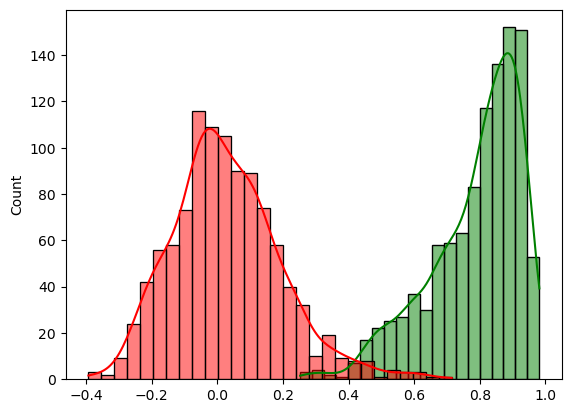

In [170]:
import seaborn as sns
sns.histplot(pos_cross_sims_s, color='green',kde=True)
 ##负样本较多，只采样一部分进行plot
sns.histplot(neg_cross_sims_s.sample(len(pos_cross_sims_s)), color='red',kde=True)

## 输出具体的结果

In [157]:
import numpy as np
def similarity(v1,v2):
    dot_product = np.dot(v1, v2)

    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)

    return dot_product / (magnitude_v1 * magnitude_v2)

In [ ]:
for i in range(len(input_question)):
    sims = similarity(emb_answer[i],emb_question[i])
    print(f"Question:{input_question[i]}\nAnswer:{input_answer[i]}\n{sims}\n")

In [177]:
input_queries = ['雷电将军好不好使？']
q_embedding = modelB.encode(input_queries)
results = util.semantic_search(query_embeddings = q_embedding,corpus_embeddings= emb_question,top_k=3)
results

Batches: 100%|██████████| 1/1 [00:00<00:00, 83.69it/s]


[[{'corpus_id': 24, 'score': 0.736361026763916},
  {'corpus_id': 880, 'score': 0.5785635709762573},
  {'corpus_id': 937, 'score': 0.5654406547546387}]]

In [178]:
for ret in results[0]:
    print(f"{all_datas[ret['corpus_id']]} score:{ret['score']}")

('除了购买之外，你还可以通过参与游戏内的活动、观看视频等方式来获得钻石。例如，完成每日任务、参加在线比赛、完成活动任务等，都会有机会获得钻石奖励。另外，你也可以尝试在对局中获得胜利、展示技巧，这样也可以提高你获得钻石的几率。', '我如何获得更多的钻石？') score:0.736361026763916
('欢乐圣诞可以为所有单位提供攻击加成效果，数值为10%。', '欢乐圣诞有什么攻击力加成效果?') score:0.5785635709762573
('爆裂之心可以增加全体会心一击伤害和出征士兵上限，其中，出征士兵上限可以增加1次。这意味着，如果你已经出征了一支军队，那么在装备了爆裂之心后，你可以再次出征一支军队。', '爆裂之心的出征士兵上限可以增加多少?') score:0.5654406547546387


# 使用pre trained 模型对比

In [179]:
modelA = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

2023-09-12 04:07:S - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
2023-09-12 04:07:S - Use pytorch device: cuda


In [180]:
emb_answer_2 = modelA.encode(input_answer)
emb_question_2 = modelA.encode(input_question)
cross_simsvalues_2 = util.cos_sim(emb_answer_2,emb_question_2).flatten()
cross_sims_s_2 = pd.Series(cross_simsvalues_2)

Batches: 100%|██████████| 33/33 [00:00<00:00, 35.79it/s]


In [181]:
len(emb_answer)

1047

In [182]:
#负样本得分
N = len(input_question)
pos_indices = [ i*N+i for i in range(N)] 
neg_cross_sims_s_2 = cross_sims_s_2.drop(pos_indices)
neg_cross_sims_s_2.describe()

count    1.095162e+06
mean     2.630461e-01
std      1.289024e-01
min     -1.849373e-01
25%      1.703907e-01
50%      2.552475e-01
75%      3.473771e-01
max      9.352317e-01
dtype: float64

In [183]:
# 正样本的得分
pos_cross_sims_s_2 = cross_sims_s_2[pos_indices]
pos_cross_sims_s_2.describe()

count    1047.000000
mean        0.642222
std         0.157302
min         0.044697
25%         0.543553
50%         0.662326
75%         0.754642
max         0.948028
dtype: float64

<Axes: ylabel='Count'>

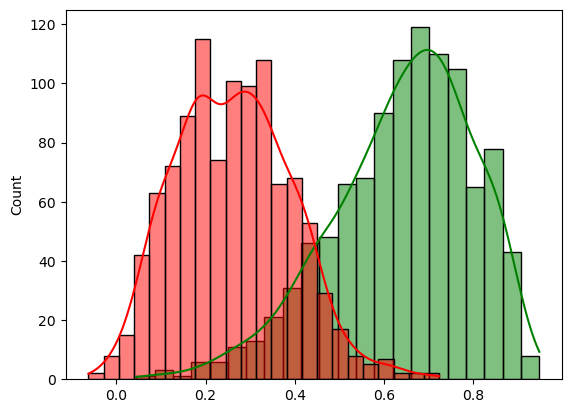

In [184]:
import seaborn as sns
sns.histplot(pos_cross_sims_s_2, color='green',kde=True)
 ##负样本较多，只采样一部分进行plot
sns.histplot(neg_cross_sims_s_2.sample(N), color='red',kde=True)

# 部署模型到sagemaker

In [57]:
!pip install --upgrade pip -q
!pip install -U sagemaker -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 2. 把模型拷贝到S3为后续部署做准备

In [21]:
import sagemaker
from sagemaker import image_uris
import boto3
import os
import time
import json

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

In [22]:
s3_model_prefix = "LLM-RAG/workshop/finetuned-sentence2emb-model"  # folder where model checkpoint will go
model_snapshot_path = "./finetuned-sentence-embedding"
s3_code_prefix = "LLM-RAG/workshop/finetuned-sentence2emb_deploy_code"
print(f"s3_code_prefix: {s3_code_prefix}")
print(f"model_snapshot_path: {model_snapshot_path}")

s3_code_prefix: LLM-RAG/workshop/finetuned-sentence2emb_deploy_code
model_snapshot_path: ./finetuned-sentence-embedding


In [23]:
!aws s3 cp --recursive {model_snapshot_path} s3://{bucket}/{s3_model_prefix}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
upload: finetuned-sentence-embedding/1_Pooling/config.json to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/1_Pooling/config.json
upload: finetuned-sentence-embedding/config_sentence_transformers.json to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/config_sentence_transformers.json
upload: finetuned-sentence-embedding/config.json to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/config.json
upload: finetuned-sentence-embedding/README.md to s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/README.md
upload: finetuned-senten

In [25]:
!pip install -U sagemaker -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.132 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0.1 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


### 3. 模型部署准备（entrypoint脚本，容器镜像，服务配置）

In [26]:
# China Region
# inference_image_uri = (
#     f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117"
# )

inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed",
    region=sess.boto_session.region_name,
    version="0.23.0"
)
print(f"Image going to be used is ---- > {inference_image_uri}")

2023-09-12 02:42:S - Ignoring unnecessary instance type: None.
Image going to be used is ---- > 763104351884.dkr.ecr.us-east-2.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


In [27]:
!mkdir -p sentence2emb_deploy_code

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
%%writefile sentence2emb_deploy_code/model.py
from djl_python import Input, Output
import torch
import logging
import math
import os
from sentence_transformers import SentenceTransformer


def load_model(properties):
    tensor_parallel = properties["tensor_parallel_degree"]
    model_location = properties['model_dir']
    if "model_id" in properties:
        model_location = properties['model_id']
    logging.info(f"Loading model in {model_location}")

    # model =  FlagModel(model_location)
    model = SentenceTransformer(model_location)
    
    return model

model = None

def handle(inputs: Input):
    global model
    if not model:
        model = load_model(inputs.get_properties())

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()
    
    input_sentences = None
    inputs = data["inputs"]
    if isinstance(inputs, list):
        input_sentences = inputs
    else:
        input_sentences =  [inputs]
        
    logging.info(f"inputs: {input_sentences}")

    sentence_embeddings =  model.encode(input_sentences,normalize_embeddings=True)
        
    result = {"sentence_embeddings": sentence_embeddings}
    return Output().add_as_json(result)

Overwriting sentence2emb_deploy_code/model.py


#### Note: option.s3url 需要按照自己的账号进行修改

In [29]:
%%writefile sentence2emb_deploy_code/serving.properties
engine=Python
option.tensor_parallel_degree=1
option.s3url = s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb-model/

Overwriting sentence2emb_deploy_code/serving.properties


In [30]:
%%writefile sentence2emb_deploy_code/requirements.txt
transformers==4.30.2
sentence-transformers

Overwriting sentence2emb_deploy_code/requirements.txt


In [31]:
!rm s2e_model.tar.gz
!cd sentence2emb_deploy_code && rm -rf ".ipynb_checkpoints"
!tar czvf s2e_model.tar.gz sentence2emb_deploy_code

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
sentence2emb_deploy_code/
se

In [32]:
s3_code_artifact = sess.upload_data("s2e_model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-2-946277762357/LLM-RAG/workshop/finetuned-sentence2emb_deploy_code/s2e_model.tar.gz


### 4. 创建模型 & 创建endpoint

In [33]:
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base("finetuned-mpnet") #Note: Need to specify model_name
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

finetuned-mpnet-2023-09-12-02-42-51-118
Image going to be used is ---- > 763104351884.dkr.ecr.us-east-2.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118
Created Model: arn:aws:sagemaker:us-east-2:946277762357:model/finetuned-mpnet-2023-09-12-02-42-51-118


###  如果批量创建索引量较多，建议改成"InstanceType": "ml.g4dn.xlarge",

In [34]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 10*60,
        },
    ],
)
endpoint_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-2:946277762357:endpoint-config/finetuned-mpnet-2023-09-12-02-42-51-118-config',
 'ResponseMetadata': {'RequestId': '4dcf93b1-883f-4699-975e-65b7dc42e845',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4dcf93b1-883f-4699-975e-65b7dc42e845',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '127',
   'date': 'Tue, 12 Sep 2023 02:42:54 GMT'},
  'RetryAttempts': 0}}

In [35]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-east-2:946277762357:endpoint/finetuned-mpnet-2023-09-12-02-42-51-118-endpoint


In [36]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-2:946277762357:endpoint/finetuned-mpnet-2023-09-12-02-42-51-118-endpoint
Status: InService


## 5. 模型测试

In [98]:
def get_vector_by_sm_endpoint(questions, sm_client, endpoint_name):
    # parameters = {
    #     "max_new_tokens": 50,
    #     "temperature": 0,
    #     "min_length": 10,
    #     "no_repeat_ngram_size": 2,
    # }

    response_model = sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "inputs": questions,
                # "parameters": parameters
            }
        ),
        ContentType="application/json",
    )
    json_str = response_model['Body'].read().decode('utf8')
    json_obj = json.loads(json_str)
    embeddings = json_obj['sentence_embeddings']
    return embeddings

In [99]:
prompts1 = """专属技能碎片在哪里获得？"""
prompts1 = """中国首都在哪里？"""

emb1 = get_vector_by_sm_endpoint(prompts1, smr_client, endpoint_name)

In [100]:
prompts2 = """专属技能碎片可以通过多种途径获得，例如礼包商城-特惠礼包界面可以购买专属技能碎片礼包"""
emb2 = get_vector_by_sm_endpoint(prompts2, smr_client, endpoint_name)

In [101]:
util.cos_sim(emb1,emb2)

tensor([[-0.0693]])